In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain-community langchain-anthropic tavily-python pandas pygithub

In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")
_set_env("TAVILY_API_KEY")
_set_env("GITHUB_APP_ID")
_set_env("GITHUB_APP_PRIVATE_KEY")
_set_env("GITHUB_REPOSITORY")

# Recommended
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "ekline-langgraph-api"
print(os.environ["GITHUB_APP_PRIVATE_KEY"])

./private-key.pem


In [3]:
from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from typing import Annotated
import re
from typing_extensions import TypedDict
from langchain_community.agent_toolkits.github.toolkit import GitHubToolkit
from langchain_community.utilities.github import GitHubAPIWrapper
from langgraph.graph.message import AnyMessage, add_messages
from langchain_core.tools import BaseTool
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.runnables import RunnableLambda
from langchain_core.messages import ToolMessage
from langgraph.prebuilt import ToolNode

def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )

def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print(f"Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

def convert_tools_name(tools) -> list[BaseTool]:
	for tool in tools:
		input_string = tool.name.lower()
		cleaned_string = re.sub(r'[^a-zA-Z0-9_-]+', ' ', input_string)
		tool.name = re.sub(r'\s+', '_', cleaned_string).strip('_')
	return tools

searchTool = [TavilySearchResults(max_results=1)]
github = GitHubAPIWrapper()
toolkit = GitHubToolkit.from_github_api_wrapper(github)
githubTools = convert_tools_name(toolkit.get_tools())


In [5]:
class State(TypedDict):
	messages: Annotated[list[AnyMessage], add_messages]

class Assistant:
	def __init__(self, runnable: Runnable):
		self.runnable = runnable

	def __call__(self, state: State, config: RunnableConfig):
		while True:
			issues = config.get("issues", None)
			state = {**state, "issues": issues}
			result = self.runnable.invoke(state)
			# If the LLM happens to return an empty response, we will re-prompt it
			# for an actual response.
			if not result.tool_calls and (
				not result.content
				or isinstance(result.content, list)
				and not result.content[0].get("text")
			):
				messages = state["messages"] + [("user", "Respond with a real output.")]
				state = {**state, "messages": messages}
			else:
				break
		return {"messages": result}


# Haiku is faster and cheaper, but less accurate
# llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm = ChatAnthropic(model="claude-3-sonnet-20240229", temperature=1)
# You could swap LLMs, though you will likely want to update the prompts when
# doing so!
# from langchain_openai import ChatOpenAI

# llm = ChatOpenAI(model="gpt-4-turbo-preview")

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful support assistant for ekline, the company, products. "
            " Use the provided github tools that can search for issues, comments on issues, solve issues, create PRs in a repositories to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
						"issues:{issues}"
        ),
        ("placeholder", "{messages}")
    ]
)
part_1_tools = (searchTool + githubTools)
part_1_assistant_runnable = primary_assistant_prompt | llm.bind_tools(part_1_tools)

builder = StateGraph(State)

In [6]:
builder.add_node("assistant", Assistant(part_1_assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(part_1_tools))
# Define edges: these determine how the control flow moves
builder.set_entry_point("assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = SqliteSaver.from_conn_string(":memory:")
part_1_graph = builder.compile(checkpointer=memory)

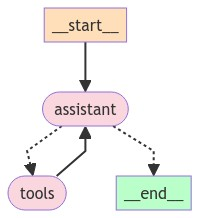

In [7]:
from IPython.display import Image, display

try:
    display(Image(part_1_graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [8]:
print(github.get_issues())

Found 1 issues:
[{'title': 'Update ReadMe file', 'number': 3, 'opened_by': 'rahilvora'}]


In [13]:
import uuid

# Let's create an example conversation a user might have with the assistant
tutorial_questions = [
    "How many open issues are present in the repository",
]

thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
        "issues": github.get_issues()
    }
}
# print(part_1_graph.get_state(config=config))

_printed = set()
for question in tutorial_questions:
    events = part_1_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)

================================ Human Message =================================

How many open issues are present in the repository
================================== Ai Message ==================================

[{'id': 'toolu_016pz1kcxtFXL6rKrwpqCTsk', 'input': {'no_input': ' '}, 'name': 'get_issues', 'type': 'tool_use'}]
Tool Calls:
  get_issues (toolu_016pz1kcxtFXL6rKrwpqCTsk)
 Call ID: toolu_016pz1kcxtFXL6rKrwpqCTsk
  Args:
    no_input:
================================= Tool Message =================================

Error: TypeError("GitHubAction._run() got an unexpected keyword argument 'no_input'")
 please fix your mistakes.
================================== Ai Message ==================================

[{'text': "Oops, it looks like that tool doesn't require any input parameters. Let me try again without passing any parameters:", 'type': 'text'}, {'id': 'toolu_01F4pZJXse8bwTMq77zqcJEV', 'input': {}, 'name': 'get_issues', 'type': 'tool_use'}]
Tool Calls:
  get_issues (tool